### Import Data and Libraries

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
from collections import defaultdict

In [17]:
import sys
import pickle
sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

In [18]:
# Remove total
data_dict.pop('TOTAL')
my_dataset = data_dict

### Create  New Variables

Two new features of email might be helpful: the proportion of poi_messages to total messages (to and from respectively)

In [19]:
for person in my_dataset:
    if (my_dataset[person]['to_messages']!='NaN')& (my_dataset[person]['to_messages']>0):
        my_dataset[person]['poi_to_rate']=float(my_dataset[person]['from_poi_to_this_person'])/my_dataset[person]['to_messages']
    else:
        my_dataset[person]['poi_to_rate']='NaN'
    if (my_dataset[person]['from_messages']!='NaN')& (my_dataset[person]['from_messages']>0):    
        my_dataset[person]['poi_from_rate']=float(my_dataset[person]['from_this_person_to_poi'])/my_dataset[person]['from_messages']
    else:
        my_dataset[person]['poi_from_rate']='NaN'


### Observe Data

In [20]:
print 'Total # of people:',len(my_dataset)
print 'Total # of features:',len(my_dataset[my_dataset.keys()[0]])

Total # of people: 145
Total # of features: 23


In [21]:
my_dataset['METTS MARK']['poi']
positive=0
negative=0
for person in my_dataset:
    if my_dataset[person]['poi']==True:
        positive+=1
    elif my_dataset[person]['poi']==False:
        negative+=1

print 'poi: ',positive
print 'non-poi: ',negative
    
    

poi:  18
non-poi:  127


In [22]:
na_count=defaultdict(int)
for person in my_dataset:
    for feature in my_dataset[person]:
        if my_dataset[person][feature]=='NaN':
            na_count[feature]+=1
print na_count

defaultdict(<type 'int'>, {'to_messages': 59, 'deferral_payments': 107, 'expenses': 51, 'deferred_income': 97, 'email_address': 34, 'from_poi_to_this_person': 59, 'poi_from_rate': 59, 'restricted_stock_deferred': 128, 'shared_receipt_with_poi': 59, 'loan_advances': 142, 'from_messages': 59, 'other': 53, 'director_fees': 129, 'bonus': 64, 'total_stock_value': 20, 'from_this_person_to_poi': 59, 'long_term_incentive': 80, 'restricted_stock': 36, 'salary': 51, 'total_payments': 21, 'poi_to_rate': 59, 'exercised_stock_options': 44})


In [23]:
def count_zero(features,check=0):
    '''
    Args: 
        check: default as 0, can be any other specific value appeared in features
        features: a standard feature list generated from featureFormat()
    Returns: 
        a list with length of # of features, each elements represents the count of specified value
    '''
    na_counter=[0]*len(features[0])
    for person in features:
        for i in range(len(features[0])):
            if person[i]==check:
                na_counter[i]+=1
    return na_counter

#### 1. Money

In [8]:
features_list = ['poi','salary', 'expenses', 'exercised_stock_options']
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

In [9]:
print 'Zero count:',count_zero(features,check=0)

Zero count: [39, 39, 32]


Seems high exercised stock option is a meaningful indicator of poi.

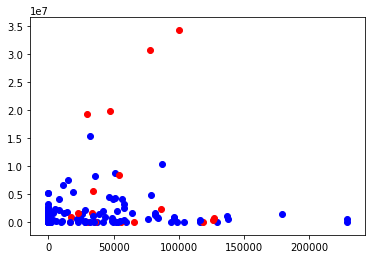

In [10]:
# plot expenses against exercised stock option
for i,label in enumerate(labels):
    if label==1:
        plt.scatter(features[i][1],features[i][2],color='r')
    else:
        plt.scatter(features[i][1],features[i][2],color='b')
plt.show()

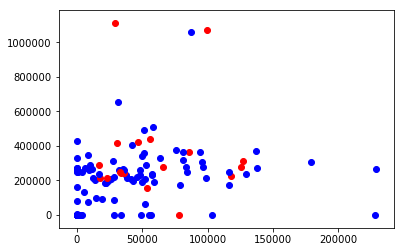

In [11]:
# plot expenses against salary
for i,label in enumerate(labels):
    if label==1:
        plt.scatter(features[i][1],features[i][0],color='r')
    else:
        plt.scatter(features[i][1],features[i][0],color='b')
plt.show()

#### 2. Email

In [12]:
features_list = ['poi','to_messages','from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi']
data = featureFormat(my_dataset, features_list, sort_keys = True,remove_NaN=False)
labels, features = targetFeatureSplit(data)

In [13]:
print 'Zero count:',count_zero(features,check=0)

Zero count: [0, 12, 0, 20]


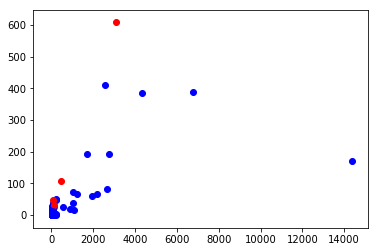

In [14]:
# plot from_message against from_this_person_to_poi
for i,label in enumerate(labels):
    if label==1:
        plt.scatter(features[i][2],features[i][3],color='r')
    else:
        plt.scatter(features[i][2],features[i][3],color='b')
plt.show()

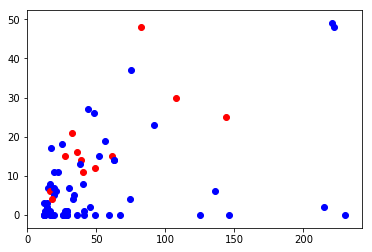

In [15]:
# plot from_message against from_this_person_to_poi (max values excluded)
for i,label in enumerate(labels):
    if (features[i][3]<300)&(features[i][2]<300):
        if label==1:
            plt.scatter(features[i][2],features[i][3],color='r')
        else:
            plt.scatter(features[i][2],features[i][3],color='b')
plt.show()

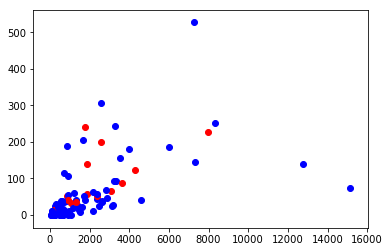

In [16]:
# plot to_message against from_poi_to_this_person
for i,label in enumerate(labels):
    if label==1:
        plt.scatter(features[i][0],features[i][1],color='r')
    else:
        plt.scatter(features[i][0],features[i][1],color='b')
plt.show()

In [17]:
features_list = ['poi','poi_from_rate','poi_to_rate']
data = featureFormat(my_dataset, features_list, sort_keys = True,remove_NaN=False)
labels, features = targetFeatureSplit(data)

Besides money features explored during the course, two newly created poi message ratio seems meaningful. POIs tend to have higher ratio.

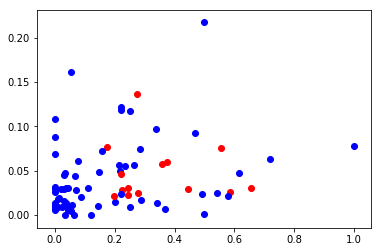

In [18]:
# plot two poi rate
for i,label in enumerate(labels):
    if label==1:
        plt.scatter(features[i][0],features[i][1],color='r')
    else:
        plt.scatter(features[i][0],features[i][1],color='b')
plt.show()

### Explore Algorithms

In [24]:
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

D:\Anaconda3\envs\python2-2\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Create a feature scaling function first for later use.

In [25]:
def feature_scaling(features):
    '''
    Args: a standard feature list generated from featureFormat()
    Return: scaled feature list
    '''
    scaled=[]
    for feature in np.array(features).T:
        min_val=min(feature)
        max_val=max(feature)
        scaled_feature=(feature-min_val)/float(max_val-min_val)
        scaled.append(scaled_feature)
    return np.array(scaled).T

#### 0. Define Tester 

In [26]:
# Revised based on tester.py
def test_classifier(clf, labels, features, folds = 1000):
    cv = StratifiedShuffleSplit(labels, folds, random_state = 42)
    true_negatives = 0
    false_negatives = 0
    true_positives = 0
    false_positives = 0
    for train_idx, test_idx in cv: 
        features_train = []
        features_test  = []
        labels_train   = []
        labels_test    = []
        for ii in train_idx:
            features_train.append( features[ii] )
            labels_train.append( labels[ii] )
        for jj in test_idx:
            features_test.append( features[jj] )
            labels_test.append( labels[jj] )
        
        clf.fit(features_train, labels_train)
        predictions = clf.predict(features_test)
        for prediction, truth in zip(predictions, labels_test):
            if prediction == 0 and truth == 0:
                true_negatives += 1
            elif prediction == 0 and truth == 1:
                false_negatives += 1
            elif prediction == 1 and truth == 0:
                false_positives += 1
            elif prediction == 1 and truth == 1:
                true_positives += 1
            else:
                print "Warning: Found a predicted label not == 0 or 1."
                print "All predictions should take value 0 or 1."
                print "Evaluating performance for processed predictions:"
                break
    try:
        total_predictions = true_negatives + false_negatives + false_positives + true_positives
        accuracy = 1.0*(true_positives + true_negatives)/total_predictions
        precision = 1.0*true_positives/(true_positives+false_positives)
        recall = 1.0*true_positives/(true_positives+false_negatives)
        print 'Accuracy:{}; Precision:{}; Recall:{};'.format(round(accuracy,3),round(precision,3),round(recall,3))
        return (accuracy,precision,recall)
    except:
        print "Got a divide by zero when trying out:", clf
        return (0,0,0)

#### 1. Gaussian NB

Observation: Not so much parameters to tune for GaussianNB. The choice of features would influence classifier's performance. Feature scaling doesn't make an obvious impact on the performance (which make sense since the algorithm of NB doesn't combine features of different measure unit).

In [27]:
from sklearn.naive_bayes import GaussianNB

In [28]:
features_list = ['poi','salary', 'expenses','bonus', 'exercised_stock_options','poi_from_rate','poi_to_rate']
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)
features=feature_scaling(features)
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.3)

In [30]:
clf=GaussianNB()
t0 = time()
clf.fit(features_train,labels_train)
print "Fitting done in %0.3fs" % (time() - t0)

print "Predicting on the testing set:"
t0 = time()
y_pred = clf.predict(features_test)
print "Done in %0.3fs" % (time() - t0)

print 'Accuracy score:',round(clf.score(features_test,labels_test),3)
print classification_report(labels_test, y_pred)
print confusion_matrix(labels_test, y_pred)

Fitting done in 0.001s
Predicting on the testing set:
Done in 0.001s
Accuracy score: 0.829
             precision    recall  f1-score   support

        0.0       0.89      0.92      0.91        37
        1.0       0.00      0.00      0.00         4

avg / total       0.81      0.83      0.82        41

[[34  3]
 [ 4  0]]


In [31]:
test_classifier(clf, labels, features, folds = 1000)

Accuracy:0.833; Precision:0.392; Recall:0.303;


(0.8331428571428572, 0.39161290322580644, 0.3035)

In [32]:
features_list = ['poi','salary', 'expenses', 'exercised_stock_options','poi_from_rate','poi_to_rate']
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.3)
test_classifier(clf, labels, features, folds = 1000)

Accuracy:0.863; Precision:0.546; Recall:0.261;


(0.8633571428571428, 0.5455497382198953, 0.2605)

In [30]:
features_list = ['poi','salary', 'expenses','bonus', 'exercised_stock_options','poi_from_rate','poi_to_rate']
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)
features=feature_scaling(features)
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.3)
test_classifier(clf, labels, features, folds = 1000)

Accuracy:0.833; Precision:0.392; Recall:0.303;


(0.8331428571428572, 0.39161290322580644, 0.3035)

#### 2. DecisionTree

Observation: the best estimator returned by GridSearchCV varies drastically for different train/test sets and the precision/recall rate is unstable. Too high max_depth usually results in overfitting. With careful tuning, desired performance is achieved (precision >.3, recall>.3).

In [33]:
from sklearn.tree import DecisionTreeClassifier

Experiment #1 with GridSearchCV cv and scoring setting:

In [34]:
features_list = ['poi','salary', 'expenses', 'bonus','poi_from_rate','poi_to_rate']
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

In [40]:
param_grid = {'max_depth':[2,3,4,5,6,7,8],
          'min_samples_split': [2,5,8,10,12,15,20],
          'min_samples_leaf':[1,2,5,8,10],
          }
cv = StratifiedShuffleSplit(labels, 100, random_state = 42)

clf_grid = GridSearchCV(DecisionTreeClassifier(), param_grid=param_grid,cv=cv,scoring='f1')

In [41]:
clf_grid.fit(features,labels)

D:\Anaconda3\envs\python2-2\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


GridSearchCV(cv=StratifiedShuffleSplit(labels=[ 0.  0. ...,  1.  0.], n_iter=100, test_size=0.1, random_state=42),
       error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'min_samples_split': [2, 5, 8, 10, 12, 15, 20], 'max_depth': [2, 3, 4, 5, 6, 7, 8], 'min_samples_leaf': [1, 2, 5, 8, 10]},
       pre_dispatch='2*n_jobs', refit=True, scoring='f1', verbose=0)

In [42]:
print "Best estimator found by grid search:"
print clf_grid.best_estimator_

Best estimator found by grid search:
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=5,
            min_samples_split=15, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')


In [43]:
clf=clf_grid.best_estimator_
test_classifier(clf, labels, features, folds = 1000)
clf.feature_importances_

Accuracy:0.813; Precision:0.42; Recall:0.32;


array([ 0.10436583,  0.02319241,  0.52243973,  0.35000204,  0.        ])

Experiment #2 with GridSearchCV cv and scoring setting:

In [44]:
features_list = ['poi','salary', 'expenses', 'exercised_stock_options','poi_from_rate','poi_to_rate']
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

In [45]:
param_grid = {'max_depth':[2,3,4,5,6,7,8],
          'min_samples_split': [2,5,8,10,12,15,20],
          'min_samples_leaf':[1,2,5,8,10],
          }
cv = StratifiedShuffleSplit(labels, 100, random_state = 42)

clf_grid = GridSearchCV(DecisionTreeClassifier(), param_grid=param_grid,cv=cv,scoring='f1')

In [46]:
t0=time()
clf_grid.fit(features,labels)
print "Fitting done in %0.3fs" % (time() - t0)

Fitting done in 68.335s


In [48]:
print "Best estimator found by grid search:"
print clf_grid.best_estimator_
clf=clf_grid.best_estimator_
test_classifier(clf, labels, features, folds = 1000)
clf.feature_importances_

Best estimator found by grid search:
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=8,
            min_samples_split=20, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
Accuracy:0.871; Precision:0.555; Recall:0.499;


array([ 0.25097105,  0.34964793,  0.        ,  0.28594119,  0.11343982])

previous attempts without GridSearchCV cv and scoring setting：

In [36]:
features_list = ['poi','salary', 'expenses', 'bonus','poi_from_rate','poi_to_rate']
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.3)
clf=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=2,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
test_classifier(clf, labels, features, folds = 1000)
print clf.feature_importances_

Accuracy:0.801; Precision:0.374; Recall:0.283;
[ 0.          0.32180293  0.37912544  0.2539904   0.04508123]


In [37]:
features_list = ['poi','salary', 'expenses', 'bonus','exercised_stock_options','poi_from_rate','poi_to_rate']
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.3)
clf=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=5,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
test_classifier(clf, labels, features, folds = 1000)
print clf.feature_importances_

Accuracy:0.824; Precision:0.367; Recall:0.32;
[ 0.          0.18167634  0.57544969  0.          0.24287396  0.        ]


In [38]:
features_list = ['poi','salary', 'expenses', 'exercised_stock_options','poi_from_rate','poi_to_rate']
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.3)
clf=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=8,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
test_classifier(clf, labels, features, folds = 1000)
print clf.feature_importances_

Accuracy:0.868; Precision:0.546; Recall:0.467;
[ 0.25097105  0.34964793  0.          0.28594119  0.11343982]


In [39]:
y_pred = clf.predict(features_test)
print 'Accuracy score:',round(clf.score(features_test,labels_test),3)
print classification_report(labels_test, y_pred)
print confusion_matrix(labels_test, y_pred)

Accuracy score: 0.951
             precision    recall  f1-score   support

        0.0       0.97      0.97      0.97        39
        1.0       0.50      0.50      0.50         2

avg / total       0.95      0.95      0.95        41

[[38  1]
 [ 1  1]]


Best output:

In [49]:
clf=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=8,
            min_samples_split=20, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

#### 3. Random Forest

Observation: Seems random forest doesn't perform better than a single tree. The precision rate is about the same but recall rate significantly drops.

In [11]:
from sklearn.ensemble import RandomForestClassifier

In [41]:
features_list =['poi','salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus',
                'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 
                'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees',
                'to_messages', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 
                'shared_receipt_with_poi','poi_from_rate','poi_to_rate']
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)
features=feature_scaling(features)
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.3)

In [42]:
param_grid = {'max_depth':[2,3,5,8,10],
              'n_estimators':[2,5,8,10,15,20],
          'min_samples_split': [2,5,8,10,12,15,20],
          'min_samples_leaf':[1,2,5,8,10],
          }
clf = GridSearchCV(RandomForestClassifier(), param_grid)

In [43]:
t0 = time()
clf.fit(features_train,labels_train)
print "Fitting done in %0.3fs" % (time() - t0)

print "Best estimator found by grid search:"
print clf.best_estimator_

print "Predicting on the testing set:"
t0 = time()
y_pred = clf.predict(features_test)
print "Done in %0.3fs" % (time() - t0)

print 'Accuracy score:',round(clf.score(features_test,labels_test),3)
print classification_report(labels_test, y_pred)
print confusion_matrix(labels_test, y_pred)

Fitting done in 98.430s
Best estimator found by grid search:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=2,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Predicting on the testing set:
Done in 0.006s
Accuracy score: 0.818
             precision    recall  f1-score   support

        0.0       0.82      1.00      0.90        36
        1.0       0.00      0.00      0.00         8

avg / total       0.67      0.82      0.74        44

[[36  0]
 [ 8  0]]


D:\Anaconda3\envs\python2-2\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [44]:
clf=clf.best_estimator_
test_classifier(clf, labels, features, folds = 1000)

Accuracy:0.867; Precision:0.5; Recall:0.086;


(0.8666666666666667, 0.5, 0.0865)

In [152]:
'''
features_list =['poi','salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus',
                'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 
                'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees',
                'to_messages', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 
                'shared_receipt_with_poi','poi_from_rate','poi_to_rate']
clf=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=15, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
test_classifier(clf, labels, features, folds = 1000)
'''

Accuracy:0.86; Precision:0.435; Recall:0.161;


(0.8602666666666666, 0.43513513513513513, 0.161)

#### 4. SVM

Observation: Played with different combination of features and parameters, the precision rate is often admirably high while the recall rate is usually painfully low. SVM is conservative and thus fails to identify many positive cases.

In [12]:
from sklearn.svm import SVC

In [51]:
features_list = ['poi','salary', 'expenses', 'exercised_stock_options','poi_from_rate','poi_to_rate']
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)
features=feature_scaling(features)
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.3)

In [52]:
param_grid = {
         'C': [1e3, 5e3, 1e4, 5e4, 1e5],
          'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
          }
clf = GridSearchCV(SVC(), param_grid)

In [53]:
t0 = time()
clf.fit(features_train,labels_train)
print "Fitting done in %0.3fs" % (time() - t0)

print "Best estimator found by grid search:"
print clf.best_estimator_

print "Predicting on the testing set:"
t0 = time()
y_pred = clf.predict(features_test)
print "Done in %0.3fs" % (time() - t0)

print 'Accuracy score:',round(clf.score(features_test,labels_test),3)
print classification_report(labels_test, y_pred)
print confusion_matrix(labels_test, y_pred)

Fitting done in 0.312s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Predicting on the testing set:
Done in 0.001s
Accuracy score: 0.878
             precision    recall  f1-score   support

        0.0       0.88      1.00      0.94        36
        1.0       0.00      0.00      0.00         5

avg / total       0.77      0.88      0.82        41

[[36  0]
 [ 5  0]]


In [54]:
clf=clf.best_estimator_
test_classifier(clf, labels, features, folds = 1000)

Accuracy:0.862; Precision:0.626; Recall:0.077;


(0.8615714285714285, 0.6260162601626016, 0.077)

#### 5. PCA+SVM

Observation: The combination seems to be even worse than simply adopting SVM. Probably should not adopt complex algorithm on a relatively small dataset.

In [13]:
from sklearn.decomposition import PCA

In [56]:
features_list =['poi','salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus',
                'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 
                'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees',
                'to_messages', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 
                'shared_receipt_with_poi','poi_from_rate','poi_to_rate']
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)
features=feature_scaling(features)
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.2)

In [57]:
n_components=10
print "Extracting the top {} components".format(n_components)
t0 = time()
pca = PCA(svd_solver='randomized',n_components=n_components, whiten=True).fit(features_train)
print "done in %0.3fs" % (time() - t0)

explained=pca.explained_variance_ratio_
print 'Top explained ratio:',explained[0]

Extracting the top 10 components
done in 0.003s
Top explained ratio: 0.326706780958


In [58]:
features_train_pca = pca.transform(features_train)
features_test_pca = pca.transform(features_test)
param_grid = {
         'C': [1e3, 5e3, 1e4, 5e4, 1e5],
          'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]
          }
clf = GridSearchCV(SVC(), param_grid)

In [59]:
t0 = time()
clf.fit(features_train_pca,labels_train)
print "Fitting done in %0.3fs" % (time() - t0)

print "Best estimator found by grid search:"
print clf.best_estimator_

print "Predicting on the testing set:"
t0 = time()
y_pred = clf.predict(features_test_pca)
print "Done in %0.3fs" % (time() - t0)

print 'Accuracy score:',round(clf.score(features_test_pca,labels_test),3)
print classification_report(labels_test, y_pred)
print confusion_matrix(labels_test, y_pred)

Fitting done in 0.363s
Best estimator found by grid search:
SVC(C=10000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.0005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Predicting on the testing set:
Done in 0.001s
Accuracy score: 0.931
             precision    recall  f1-score   support

        0.0       0.93      1.00      0.96        26
        1.0       1.00      0.33      0.50         3

avg / total       0.94      0.93      0.92        29

[[26  0]
 [ 2  1]]


In [60]:
clf=clf.best_estimator_
test_classifier(clf, labels, pca.transform(features), folds = 1000)

Accuracy:0.848; Precision:0.326; Recall:0.13;


(0.8482, 0.32578616352201256, 0.1295)

#### 6. PCA+DecisionTree

Observation: The outcome is similiar to PCA+SVM, and the performance didn't exceed adopting DecisionTree only.

In [20]:
features_list =['poi','salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus',
                'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 
                'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees',
                'to_messages', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 
                'shared_receipt_with_poi','poi_from_rate','poi_to_rate']
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)
features=feature_scaling(features)
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.2)

Extracting the top 21 components
done in 0.003s
Explained ratio: [  3.02181259e-01   1.49757954e-01   1.04807597e-01   8.56440568e-02
   7.63988465e-02   6.46304586e-02   4.10465201e-02   3.49330434e-02
   3.36893389e-02   2.24396308e-02   2.03603111e-02   1.55799525e-02
   1.28952470e-02   1.00748526e-02   8.44224776e-03   7.84583374e-03
   3.96341127e-03   3.55466045e-03   1.73650529e-03   1.82632419e-05
   1.08238800e-08]


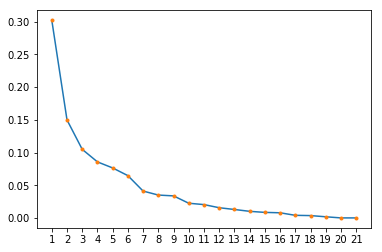

In [50]:
n_components=len(features_list)-1
print "Extracting the top {} components".format(n_components)
t0 = time()
pca = PCA(svd_solver='randomized',n_components=n_components, whiten=True).fit(features_train)
print "done in %0.3fs" % (time() - t0)

explained=pca.explained_variance_ratio_
print 'Explained ratio:',explained

plt.plot(range(1,len(explained)+1),explained)
plt.plot(range(1,len(explained)+1),explained,'.')
plt.xticks(range(1,len(explained)+1))
plt.show()

As the plot indicated, top 1 component explained much more variance than the following ones. Keeping the top 6 components is a reasonable approach.

In [45]:
n_components=6
print "Extracting the top {} components".format(n_components)
t0 = time()
pca = PCA(svd_solver='randomized',n_components=n_components, whiten=True).fit(features_train)
print "done in %0.3fs" % (time() - t0)


Extracting the top 6 components
done in 0.002s


In [46]:
features_train_pca = pca.transform(features_train)
features_test_pca = pca.transform(features_test)
param_grid = {'max_depth':[5,8,10,12,15,20,25,30,35,50],
          'min_samples_split': [2,5,8,10,12,15,20],
          'min_samples_leaf':[1,2,5,8,10],
          }
clf = GridSearchCV(DecisionTreeClassifier(), param_grid)

In [47]:
t0 = time()
clf.fit(features_train_pca,labels_train)
print "Fitting done in %0.3fs" % (time() - t0)

print "Best estimator found by grid search:"
print clf.best_estimator_

print "Predicting on the testing set:"
t0 = time()
y_pred = clf.predict(features_test_pca)
print "Done in %0.3fs" % (time() - t0)

print 'Accuracy score:',round(clf.score(features_test_pca,labels_test),3)
print classification_report(labels_test, y_pred)
print confusion_matrix(labels_test, y_pred)

Fitting done in 2.505s
Best estimator found by grid search:
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=5,
            min_samples_split=20, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
Predicting on the testing set:
Done in 0.001s
Accuracy score: 0.897
             precision    recall  f1-score   support

        0.0       0.93      0.96      0.95        27
        1.0       0.00      0.00      0.00         2

avg / total       0.86      0.90      0.88        29

[[26  1]
 [ 2  0]]


In [48]:
clf=clf.best_estimator_
test_classifier(clf, labels, pca.transform(features), folds = 1000)

Accuracy:0.799; Precision:0.12; Recall:0.08;


(0.7992666666666667, 0.12021036814425244, 0.08)

### Conclusion

- Taking the performance of both precision and recall into consideration, the best algorithm turns out to be DecisionTreeClassifier (with features and parameters below).
- Though the dimension of features is really high, the dataset is small (~150 people), so more complex algorithms didn't add any value, sometimes even make the outcome worse.

In [ ]:
'''
features_list = ['poi','salary', 'expenses', 'exercised_stock_options','poi_from_rate','poi_to_rate']
clf=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=8,
            min_samples_split=20, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
'''